# SBB Dataset visualization
26.06.2021

# Projekt-Aufgabe: 

Visualisierung der Auslastung der Strecken im SBB Netz für die letzten drei Jahre.

## Ideen:
- Netzwerk visualisieren
 - Wichtigste Verkehrsknotenpunkte bestimmen
 - Güterverkehr und Personenverkehr für die drei vergangenen Jahre vergleichen (sieht man die Corona Pandemie)
 - Den kürzesten längsten Weg im Netzwerk finden


## Nutzungsbedingungen für die Überlassung von als Open Data definierten Daten der SBB AG

### 1. Umfang der Datennutzung

Auf data.sbb.ch stehen die als Open Data definierten Inhalte in maschinell lesbarer Form zur freien Verfügung. Der Zugang zu den Daten erfolgt über data.sbb.ch. Die bezogenen Daten dürfen gemäss den nachfolgenden Bestimmungen aufbereitet, analysiert und publiziert werden, inkl. Einbezug weiterer Daten.

### 2. Registrierung

Der Bezug und die Nutzung von dateibasierten Daten der data.sbb.ch benötigt keine Registrierung und ist kostenlos, wobei bei einer anonymen Nutzung die Anzahl Requests limitiert ist (vgl. Ziffer 3). Für eine höhere Anzahl Requestsbedarf es einer Registrierung .

Basierend auf der Registrierung wird für die Nutzung der dienstbasierten Daten ein Zugriffscode (API-Key) vergeben. Der Zugriffscode kann durch die SBB widerrufen oder blockiert werden, insbesondere wenn die Pflichten gemäss Ziffer 4 nicht eingehalten werden.

### 3. Request-Limit

Für die Nutzung von dienstbasierten Daten von data.sbb.ch wird als Nutzungslimite eine maximale Anzahl Requests pro Zeiteinheit festgelegt. Innerhalb der Limite ist die Nutzung der Datendienste kostenlos.

Das Limit gilt einzeln für jeden registrierten Benutzer, für die anonyme Nutzung gilt die Limite insgesamt.

Wird die festgelegte Anzahl Requests pro Zeiteinheit überschritten, wird der Account bis zum Beginn einer neuen Zeitperiode blockiert.

Die Request – Limite ist im Benutzerprofil ersichtlich.


### 4. Pflichten der Datenbezüger

4.1. Quellenangabe

In Publikationen und Analysen ist die URL data.sbb.ch als Bezugsort der Rohdaten anzugeben.

Wenn die Daten Bestandteil eines Datenbankwerks werden, das viele verschiedene Datenquellen hat und nicht nur die Daten von data.sbb dort verwendet, genügt eine Nennung von sbb.ch in einer Liste der Beitragenden zu diesem Datenbankwerk. Es genügt eine indirekte Nennung durch einen Verweis auf Herausgeber des Datenbankwerks, der wiederum auf sbb.ch verweist. Die Einstufung “Datenbankwerk” erfolgt durch die SBB und kann bei data@sbb.ch beantragt werden. Die SBB führt eine Liste über die zugelassenen Datenbankwerke.

4.2 Aktualisierung der Rohdaten

Im Falle von für Publikationen aufbereitete Daten verpflichtet sich der Datenbezüger zu einer dem Verwendungszweck angemessenen regelmässigen Aktualisierung der zugrundeliegenden Rohdaten.

Notwendige Installation von zusätzlichen Paketen

#### Install cartopy on deepnote (Alternative zu Basemap):
!apt-get update<br>
!apt-get install libproj-dev proj-data proj-bin<br>
!apt-get install libgeos-dev<br>
!pip install cython<br>
!pip install cartopy<br>
#uncomment lines below if graph is not created due to kernel interupt
#!pip uninstall -y shapely
#!pip install shapely --no-binary shapely

In [2]:
%%time
%%capture
!apt-get update
!apt-get autoremove
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install geopy

CPU times: user 481 ms, sys: 110 ms, total: 590 ms
Wall time: 1min 49s


#### Module laden

In [3]:
%%time
import time
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import requests #to send API requests
from matplotlib.offsetbox import AnchoredText
from operator import itemgetter
import geopy.distance

CPU times: user 1.33 s, sys: 230 ms, total: 1.56 s
Wall time: 3 s


# Definieren der Funktionen um SBB Daten mit dem API auszulesen
## get_SBB_dataset()
#### gibt Datensatz zurück:

In [66]:
def get_SBB_dataset(dataset, max_rows, geschaeftscode='nan', jahr='nan'):
    #remark, the API does not allow to get more than 10'000 records/hits.
    if(geschaeftscode=='nan' and jahr=='nan'):
        api_request_string=f'https://data.sbb.ch/api/records/1.0/search/?dataset={dataset}&q=&rows={max_rows}'
    else:
        api_request_string=f"https://data.sbb.ch/api/records/1.0/search/?dataset={dataset}&q=&rows={max_rows}&sort=jahr&facet=isb&facet=strecke_nummer&facet=strecke_bezeichnung&facet=strecke_art&facet=bp_von_abschnitt&facet=bp_bis_abschnitt&facet=geschaeftscode&facet=jahr&refine.jahr={jahr}&refine.geschaeftscode={geschaeftscode}"
    response = requests.get(api_request_string)
    return response

## get_nbr_of_rec_SBB_data() 
#### gibt Anzahl Records einer Abrage zurück:

In [67]:
def get_nbr_of_rec_SBB_data(dataset, geschaeftscode, jahr):
    response=get_SBB_dataset(dataset, '0', geschaeftscode, jahr)
    json = response.json()
    return json['nhits']

# Laden aller Zugszahlen für den Gütervekehr im Jahr 2020

In [68]:
%%time
dataset='zugzahlen'
geschaeftscode='GUETERVERKEHR'
#geschaeftscode='PERSONENVERKEHR'
jahr='2020'
nbr_of_rows=get_nbr_of_rec_SBB_data(dataset, geschaeftscode, jahr)
response=get_SBB_dataset(dataset, nbr_of_rows, geschaeftscode, jahr)
json = response.json()

CPU times: user 157 ms, sys: 3.92 ms, total: 161 ms
Wall time: 4.41 s


### Zeige die Struktur des zurückgegebenen json files

In [69]:
json.keys()

dict_keys(['nhits', 'parameters', 'records', 'facet_groups'])

#### Das Json File ist eine Dictionary mit 4 Keys. Die Daten befinde sich in dem Eintrag 'records'. Dort sind die Daten in Form einer Liste abgelegt. Diese Liste lesen wir jetzt als Pandas Dataframe ein

### Speichern der Daten in einen Pandas Dataframe

In [70]:
df = pd.DataFrame(json['records'])


#### In diesem Dataframe haben wir eine Spalte 'fields'. Dort sind alle intersannten Werte jedes Streckenabschnitts als Dictionaries abgelegt. Alle diese Einträge in den den Dictionaries spliten wir jetzt in einzelne Spalten.

In [71]:
df=pd.concat([df.drop(['fields'], axis=1), df['fields'].apply(pd.Series)], axis=1)

### Nun schauen wir was wir alles für Spalten in unserem Pandas Dataframe haben:

In [72]:
print(df.columns.values)

['datasetid' 'recordid' 'geometry' 'record_timestamp' 'bp_von_abschnitt'
 'geoshape' 'geopos_von' 'bpuic' 'geopos' 'meteo' 'tu_nummer' 'geopos_bis'
 'bp_von_abschnitt_bezeichnung' 'strecke_bezeichnung' 'pid_abschnitt'
 'didok' 'lod' 'jahr' 'bp_bis_abschnitt' 'strecke_nummer'
 'bp_bis_abschnitt_bezeichnung' 'gesamtbelastung_bruttotonnen'
 'bezeichnung_offiziell' 'in_richtung' 'plz' 'anzahl_zuege'
 'geschaeftscode' 'geo_point_2d' 'strecke_art' 'isb']


### Der Übersicht halber löschen wir einige Spalten die wir vorläufig nicht gebrauchen

In [73]:
df=df.drop(['datasetid', 'recordid', 'geometry', 'record_timestamp', 'meteo', 'geoshape', 'geo_point_2d', 'geschaeftscode', 'jahr', 'lod', 'tu_nummer', 'bpuic', 'geopos'], axis=1)

In [74]:
df.head()

,bp_von_abschnitt,geopos_von,geopos_bis,bp_von_abschnitt_bezeichnung,strecke_bezeichnung,pid_abschnitt,didok,bp_bis_abschnitt,strecke_nummer,bp_bis_abschnitt_bezeichnung,gesamtbelastung_bruttotonnen,bezeichnung_offiziell,in_richtung,plz,anzahl_zuege,strecke_art,isb
0,LEN,"7.36655367635, 47.1794314233","7.38961866289, 47.1916982051",Lengnau,Moutier - Lengnau,BLS_LEN_GN,159.0,GN,301,Grenchen Nord,104746.0,Grenchen Nord,False,2540,326.0,STRECKE,BLS
1,TBL,"7.38592541364, 47.2317412363","7.38104429627, 47.2806725175",Tunnelblock (Grenchenberg),Moutier - Lengnau,BLS_TBL_MOU,105.0,MOU,301,Moutier,103977.0,Moutier,False,2740,320.0,STRECKE,BLS
2,FAWA,"7.03465000188, 47.0092400014","7.05644227051, 47.0093636268",Fanelwald,Neuchâtel Mail - Ins,BLS_FAWA_GP,4482.0,GP,302,Gampelen,313246.0,Gampelen,False,3236,961.0,STRECKE,BLS
3,GP,"7.05644227051, 47.0093636268","7.09956100561, 46.999831409",Gampelen,Neuchâtel Mail - Ins,BLS_GP_INS,4483.0,INS,302,Ins,313246.0,Ins,False,3232,961.0,STRECKE,BLS
4,ZBR,"7.03057315632, 47.0092770776","7.03465000188, 47.0092400014",Zihlbrücke,Neuchâtel Mail - Ins,BLS_ZBR_FAWA,17408.0,FAWA,302,Fanelwald,258366.0,Fanelwald,True,3236,879.0,STRECKE,BLS


### Fehlende Koordinaten dem Datensatz hinzufügen

In [75]:
def get_coordinates_url(city):
    city=city.split(' ')
    city=city[0]
    answer= f"https://nominatim.openstreetmap.org/search?city={city}&format=json"
    response = requests.get(answer)
    response.json()
    output=response.json()
    return output[0]['lon'] + ', ' + output[0]['lat']

In [76]:
print('Totale Anzahl: ',len(df['geopos_von']))
print('Anzahl vollständiger Elemente: ', df['geopos_von'].count())
#print(df['geopos_von'].head())
#df[['geopos_von','bp_von_abschnitt_bezeichnung']].to_csv('fehlendeKoordinaten.csv')

Totale Anzahl:  2949
Anzahl vollständiger Elemente:  2939


In [77]:
%%time
for i in range(len(df)):
    pos_i_coordinates=df['geopos_von'].iloc[i]
    if(isinstance(pos_i_coordinates, float)):
        pos_i_name=df['bp_von_abschnitt_bezeichnung'].iloc[i]
        pos_i_key=df['bp_von_abschnitt'].iloc[i]
        pos_i_coordinates=get_coordinates_url(pos_i_name)
        print("Found: ", pos_i_key, " (", pos_i_name, " with coordinates ", pos_i_coordinates, ")")
        df.loc[df.bp_von_abschnitt == pos_i_key, 'geopos_von']= pos_i_coordinates
        df.loc[df.bp_bis_abschnitt == pos_i_key, 'geopos_bis']= pos_i_coordinates
        time.sleep(5)

Found:  JES  ( Jestetten Süd  with coordinates  8.56667, 47.65 )
Found:  LOT  ( Lottstetten  with coordinates  8.5736163, 47.6275156 )
Found:  KOGA  ( Konstanz Grenze (Abzw)  with coordinates  9.1750718, 47.659216 )
Found:  JE  ( Jestetten  with coordinates  8.56667, 47.65 )
CPU times: user 186 ms, sys: 3.9 ms, total: 189 ms
Wall time: 21.3 s


### Geopositionen in Longitude und Latitute aufsplitten

In [78]:
temp = df['geopos_von'].str.split(", ", n = 1, expand = True)
df['geopos_von_lon']=temp[0].astype(float)
df['geopos_von_lat']=temp[1].astype(float)
temp = df['geopos_bis'].str.split(", ", n = 1, expand = True)
df['geopos_bis_lon']=temp[0].astype(float)
df['geopos_bis_lat']=temp[1].astype(float)

### Streckenabschnitt Distanzen (in km) erhalten

##### Erster (missratener) Versuch, mittels Merging von anderem SBB Datensatz
###### Polygon Datendsatz laden (Dieser Datensatz hat Strecken Distanzen)
```Python
response = get_SBB_dataset('linie-mit-polygon', 10000)
json_polygon = response.json()
df_polygon = pd.DataFrame(json_polygon['records'])
df_polygon = pd.concat([df_polygon.drop(['fields'], axis=1), df_polygon['fields'].apply(pd.Series)], axis=1)
df_polygon['distanz']=df_polygon['km_agm_bis']-df_polygon['km_agm_von']
#df_polygon['distanz1']=geopy.distance.distance(df_polygon['geopos_von'],df_polygon['geopos_bis']).km
df_polygon.columns = ['bp_von_abschnitt' if x=='bp_anfang' else x for x in df_polygon.columns]
df_polygon.columns = ['bp_bis_abschnitt' if x=='bp_ende' else x for x in df_polygon.columns]
pd.merge(df, df_polygon,  how='left', left_on=['bp_von_abschnitt','bp_bis_abschnitt'], right_on = ['bp_von_abschnitt','bp_bis_abschnitt'])
```
###### Problem: Es sind nur gewisse, bei weitem nicht alle Streckenabschnitte enthalten

##### Zweiter Versuch: Distanz aus Koordinaten berechnen:

In [79]:
# Funktion welche Diastanz in km zwischen zwei Geokoordinaten berechnet
def calc_distance(from_lat, from_long, to_lat, to_long):
    return round(geopy.distance.distance((from_lat, from_long), (to_lat, to_long)).km,2)

df['distance'] = df.apply(lambda row: calc_distance(row.geopos_von_lat, row.geopos_von_lon, row.geopos_bis_lat, row.geopos_bis_lon), axis=1)

### Fehlende Werte im Datensatz mit 0 auffüllen

In [80]:
#is not needed probaby
df.dropna(subset = ["bp_von_abschnitt", "bp_bis_abschnitt"], inplace=True)
#is not needed probaby
df[['anzahl_zuege', 'gesamtbelastung_bruttotonnen']] = df[['anzahl_zuege','gesamtbelastung_bruttotonnen']].fillna(value=0)

# Network Visualization

In [81]:
%%time
g = nx.Graph()
edges = df.groupby(['bp_von_abschnitt','bp_bis_abschnitt'],as_index=False).agg({'anzahl_zuege':'sum','gesamtbelastung_bruttotonnen':'sum', 'distance': 'first'}).rename(columns={'gesamtbelastung_bruttotonnen' : 'belastung'}) 
g = nx.from_pandas_edgelist(edges,source='bp_von_abschnitt',target='bp_bis_abschnitt',edge_attr=('anzahl_zuege','belastung', 'distance'))
print(len(g.nodes()), len(g.edges()))

1339 1482
CPU times: user 35 ms, sys: 0 ns, total: 35 ms
Wall time: 36.2 ms


#### Wir nehmen nur die Grösste verbundene Komponente für die Auswertung

In [82]:
%%time
sg = next(g.subgraph(c) for c in nx.connected_components(g))
print(len(sg.nodes()), len(sg.edges))
mst=nx.minimum_spanning_tree(sg)
print(len(mst))

1339 1482
1339
CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 130 ms


In [89]:
print(nx.info(sg))

Name: 
Type: Graph
Number of nodes: 1339
Number of edges: 1482
Average degree:   2.2136


#### Erstellen von Dictionary für die Stationen

In [83]:
%%time
# stations with latitude and longitude
# get all labels
labels_all = {}
stations = {}
for index, row in df.iterrows():
    if not row['bp_von_abschnitt'] in stations:
        stations[row['bp_von_abschnitt']] = (row['geopos_von_lon'], row['geopos_von_lat'])
        labels_all[row['bp_von_abschnitt']] = row['bp_von_abschnitt_bezeichnung']
    if not row['bp_bis_abschnitt'] in stations:
        stations[row['bp_bis_abschnitt']] =  (row['geopos_bis_lon'], row['geopos_bis_lat'])
        labels_all[row['bp_bis_abschnitt']] =  row['bp_bis_abschnitt_bezeichnung']
len(stations)

CPU times: user 669 ms, sys: 20 µs, total: 669 ms
Wall time: 722 ms


1339

### Hinzufügen von Stationsnamen und Koordinaten als Attributes der Knoten und Exportieren als gexf Datei für gephi 

In [58]:
%%time
#Trennen von lat und long 
x_val = {}
y_val = {}
for i in stations:
    x_val[i] = stations[i][0]
    y_val[i] = stations[i][1]

nx.set_node_attributes(g,labels_all,name='label')
nx.set_node_attributes(g,x_val,name='long')
nx.set_node_attributes(g,y_val,name='lat')


nx.write_gexf(g , "./sbb.gexf" )

CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 482 ms


<h3>Ansicht der exportierten Daten mittels Gephi mittels Geo-Layout</h3>
weight = Anzahl der Güter-Züge

Allerdings: konstante Crashes von Gephi :(

<img src="gephi_Anzahl_Zuege.png">

### Berechnen von betweeness centrality / closeness centrality und eigenvector für die Node Labels bzw zusaetzliche Nodes in gruen

In [84]:
%%time
#betweenness centrality
threshold_bc=0.41
betweenness_centrality=nx.betweenness_centrality(sg)
labels_bc = {code: labels_all[code] if betweenness_centrality[code] >= threshold_bc else '' for code in sg.nodes}
betweennes_graph=nx.subgraph(sg,[x for x in sg.nodes() if betweenness_centrality[x]>threshold_bc])

#closeness centrality
threshold_cc=0.027
closeness_centrality=nx.closeness_centrality(sg)
labels_cc = {code: labels_all[code] if closeness_centrality[code] >= threshold_cc else '' for code in sg.nodes}
closeness_graph=nx.subgraph(sg,[x for x in sg.nodes() if closeness_centrality[x]>threshold_cc])

# eigenvector centrality
threshold_ev=0.3
eigenvector_centrality=nx.eigenvector_centrality(sg)
labels_ev = {code: labels_all[code] if eigenvector_centrality[code] >= threshold_ev else '' for code in sg.nodes}
eigenvector_graph=nx.subgraph(sg,[x for x in sg.nodes() if eigenvector_centrality[x]>threshold_ev])

CPU times: user 1min 21s, sys: 139 ms, total: 1min 21s
Wall time: 1min 27s


### Extrahieren Bruttotonnen  und Anzahl Zuege für die Edge widths und Edge Colors in der Abbildung

In [85]:
edges = sg.edges()
anzahl_zuege = [sg[u][v]['anzahl_zuege'] for u,v in edges]
belastung = [sg[u][v]['belastung']/10000000 for u,v in edges]

CPU times: user 6.94 s, sys: 221 ms, total: 7.16 s
Wall time: 7.2 s


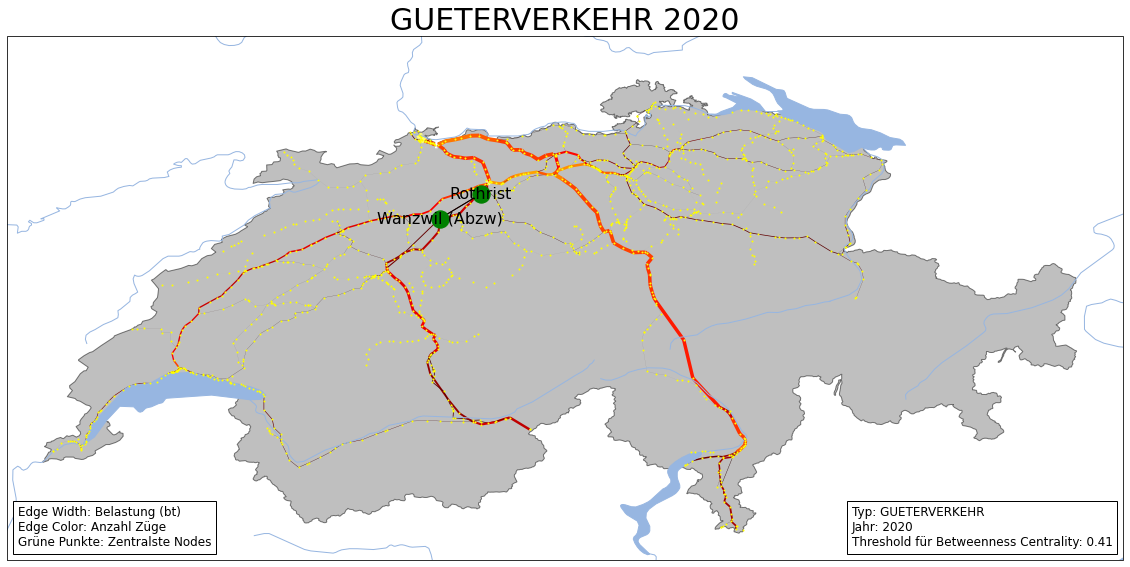

In [91]:
%%time
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),
    subplot_kw=dict(projection=crs))
ax.coastlines()
ax.set_global()
ax.set_extent([10.7, 5.8, 45.7, 48], crs=ccrs.PlateCarree())
ax.set_title(geschaeftscode +' ' + jahr, fontsize=30)

adm1_shapes = list(shpreader.Reader('.//data//shapes//gadm36_CHE_0//gadm36_CHE_0.shp').geometries()) #https://gadm.org/download_country_v3.html
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='gray', alpha=0.5, zorder=0)
ax.add_feature(cfeature.LAKES, alpha=1)
ax.add_feature(cfeature.RIVERS)

text = AnchoredText('Typ: {} \nJahr: {} \nThreshold für Betweenness Centrality: {}'
                        ''.format(geschaeftscode, jahr, threshold_bc),
                    loc=4, prop={'size': 12}, frameon=True)

text2 = AnchoredText('Edge Width: {} \nEdge Color: {} \nGrüne Punkte: {}'
                        ''.format('Belastung (bt)', 'Anzahl Züge', 'Zentralste Nodes'),
                    loc=3, prop={'size': 12}, frameon=True)  

ax.add_artist(text)
ax.add_artist(text2)

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 font_color='black',
                 with_labels=True,
                 alpha=1,
                 width=belastung,
                 node_size=1,
                 labels=labels_bc,
                 pos=stations,
                 node_color='yellow',
                 edge_color=anzahl_zuege,
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )


nx.draw_networkx(betweennes_graph, ax=ax,
                with_labels=False,
                 font_color='yellow',
                 pos=stations,
                 node_color="green"
                )
fig.savefig('SBB_Line_'+geschaeftscode+'_'+jahr+'.png', dpi=500)

#### Das Ganze in Zahlen:

In [87]:
print("Durchschnittliche Belastung der Gleise pro Jahr:\n" + str(round(df['gesamtbelastung_bruttotonnen'].mean(),0))+' Bruttotonnen ± ' +str(round(df['gesamtbelastung_bruttotonnen'].std(),0)))
print("Durchschnittliche Anzahl Züge pro Jahr und Abschnitt:\n" + str(round(df['anzahl_zuege'].mean(),0))+'±'+str(round(df['anzahl_zuege'].std(),0)))
print("Maximale Anzahl Züge pro Jahr und Abschnitt:\n" +str(round(df['anzahl_zuege'].max(),0))+" => ca. "+ str(round(df['anzahl_zuege'].max()/365/24/60,2))+ ' Zug pro Minute')


Durchschnittliche Belastung der Gleise pro Jahr:
3326230.0 Bruttotonnen ± 5546597.0
Durchschnittliche Anzahl Züge pro Jahr und Abschnitt:
4140.0±5799.0
Maximale Anzahl Züge pro Jahr und Abschnitt:
39219.0 => ca. 0.07 Zug pro Minute


<h3>Vergleich mit Passagierverkehr 2020</h3>

<img src="SBB_Line_PERSONENVERKEHR_2020_cropped.png">

Durchschnittliche Belastung der Gleise pro Jahr:<br>
7695012.0 Bruttotonnen ± 9801609.0<br>
Durchschnittliche Anzahl Züge pro Jahr und Abschnitt:<br>
24845.0±24382.0<br>
Maximale Anzahl Züge pro Jahr und Abschnitt:<br>
362172.0 => ca. 0.62 Züge pro Minute<br>

<h3>Vergleich mit Passagierverkehr 2019</h3>

<img src="SBB_Line_PERSONENVERKEHR_2019_cropped.png">


Durchschnittliche Belastung der Gleise pro Jahr:<br>
7808928.0 Bruttotonnen ± 9963896.0<br>
Durchschnittliche Anzahl Züge pro Jahr und Abschnitt:<br>
25131.0±24760.0<br>
Maximale Anzahl Züge pro Jahr und Abschnitt:<br>
378853.0 => ca. 0.68 Züge pro Minute<br>

## Finden der längsten Strecke

##### Approach 1
###### Iteration mit nx.shortest_path_length() über alle möglichen Paare
###### -> Ist zu rechenintensiv

```Python
def get_station_keys(stations, i):
    coordinates=list(stations.keys())[i]
    return coordinates

# Function to find the maximum
# distance between any two points
def maxDist(p):

	n = len(p)
	maxm = 0

	# Iterate over all possible pairs
	for i in range(n):
		for j in range(i + 1, n):
            # Update maxm
			distance = nx.shortest_path_length(sg, get_station_keys(p,i), get_station_keys(p,j), 'distance')
			if(distance>maxm):
				maxm=distance
				mostdistance_nodes=get_station_keys(p,i), get_station_keys(p,j)
	# Return actual distance and nodes
	return maxm, mostdistance_nodes
	
max_distance, max_distance_nodes = maxDist(stations)
```

##### Approach 2
###### Kürzester Pfad zwischen geografisch weitest entfernten Nodes
###### -> Viel schneller ## 

In [56]:
%%time
def get_station_coordiantes(stations, i):
    coordinates=list(stations.values())[i]
    return coordinates

def get_station_keys(stations, i):
    coordinates=list(stations.keys())[i]
    return coordinates

# Function calculates squared distance
# between two points
def dist(p1, p2):
	
	x0 = p1[0] - p2[0]
	y0 = p1[1] - p2[1]
	return x0 * x0 + y0 * y0

# Function to find the maximum
# distance between any two points
def maxDist(p):

	n = len(p)
	maxm = 0

	# Iterate over all possible pairs
	for i in range(n):
		for j in range(i + 1, n):
			
			# Update maxm
			distance= dist(get_station_coordiantes(p,i), get_station_coordiantes(p,j))
			if(distance>maxm):
				maxm=distance
				mostdistance_nodes=get_station_keys(p,i), get_station_keys(p,j)
	distance=nx.shortest_path_length(sg, mostdistance_nodes[0], mostdistance_nodes[1], 'distance')
	path=nx.shortest_path(sg, mostdistance_nodes[0], mostdistance_nodes[1], 'distance')

	# Return actual distance
	return distance, path
	
distance, path = maxDist(stations)

CPU times: user 34.4 s, sys: 55.4 ms, total: 34.5 s
Wall time: 37.5 s


CPU times: user 8.42 s, sys: 247 ms, total: 8.67 s
Wall time: 9.58 s


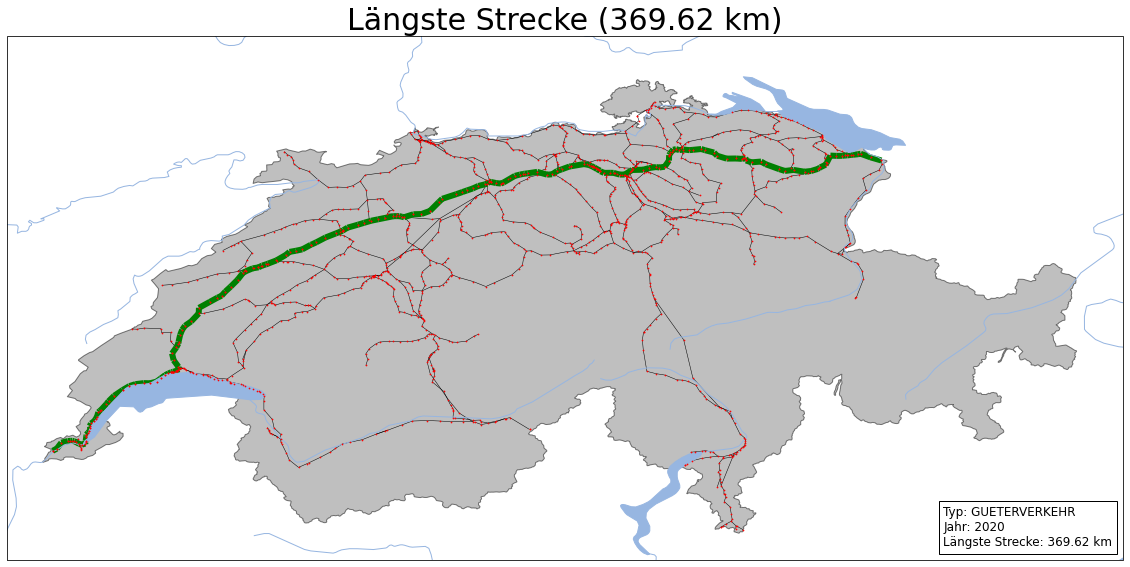

In [88]:
%%time
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),
    subplot_kw=dict(projection=crs))
ax.coastlines()
ax.set_global()
ax.set_extent([10.7, 5.8, 45.7, 48], crs=ccrs.PlateCarree())
ax.set_title('Längste Strecke ('+ str(round(distance, 2))+" km)", fontsize=30)

adm1_shapes = list(shpreader.Reader('.//data//shapes//gadm36_CHE_0//gadm36_CHE_0.shp').geometries()) #https://gadm.org/download_country_v3.html
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='gray', alpha=0.5, zorder=0)
ax.add_feature(cfeature.LAKES, alpha=1)
ax.add_feature(cfeature.RIVERS)

text = AnchoredText('Typ: {} \nJahr: {} \nLängste Strecke: {}'
                        ''.format(geschaeftscode, jahr, str(round(distance, 2))+" km"),
                    loc=4, prop={'size': 12}, frameon=True)
ax.add_artist(text)

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 font_color='black',
                 with_labels=False,
                 alpha=1,
                 width=0.5,
                 node_size=0.5,
                 pos=stations,
                 node_color='red',
                 edge_color='black',
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )

nx.draw_networkx(sg.subgraph(path), ax=ax,
                 font_size=16,
                 font_color='black',
                 with_labels=False,
                 alpha=1,
                 width=6,
                 node_size=0.5,
                 pos=stations,
                 node_color='red',
                 edge_color='green',
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )

fig.savefig('SBB_Line_'+geschaeftscode+'_'+jahr+'.png', dpi=500)

Zeichne die Karte für betweenness centrality (Teil der kürzesten Pfade, die durch diesen Knoten gehen), closeness centrality (Inverse der Summe aller kürzesten Pfade) and eigenvector centrality (Einfluss eines Knotens)

CPU times: user 3.4 s, sys: 7.37 ms, total: 3.41 s
Wall time: 3.78 s


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

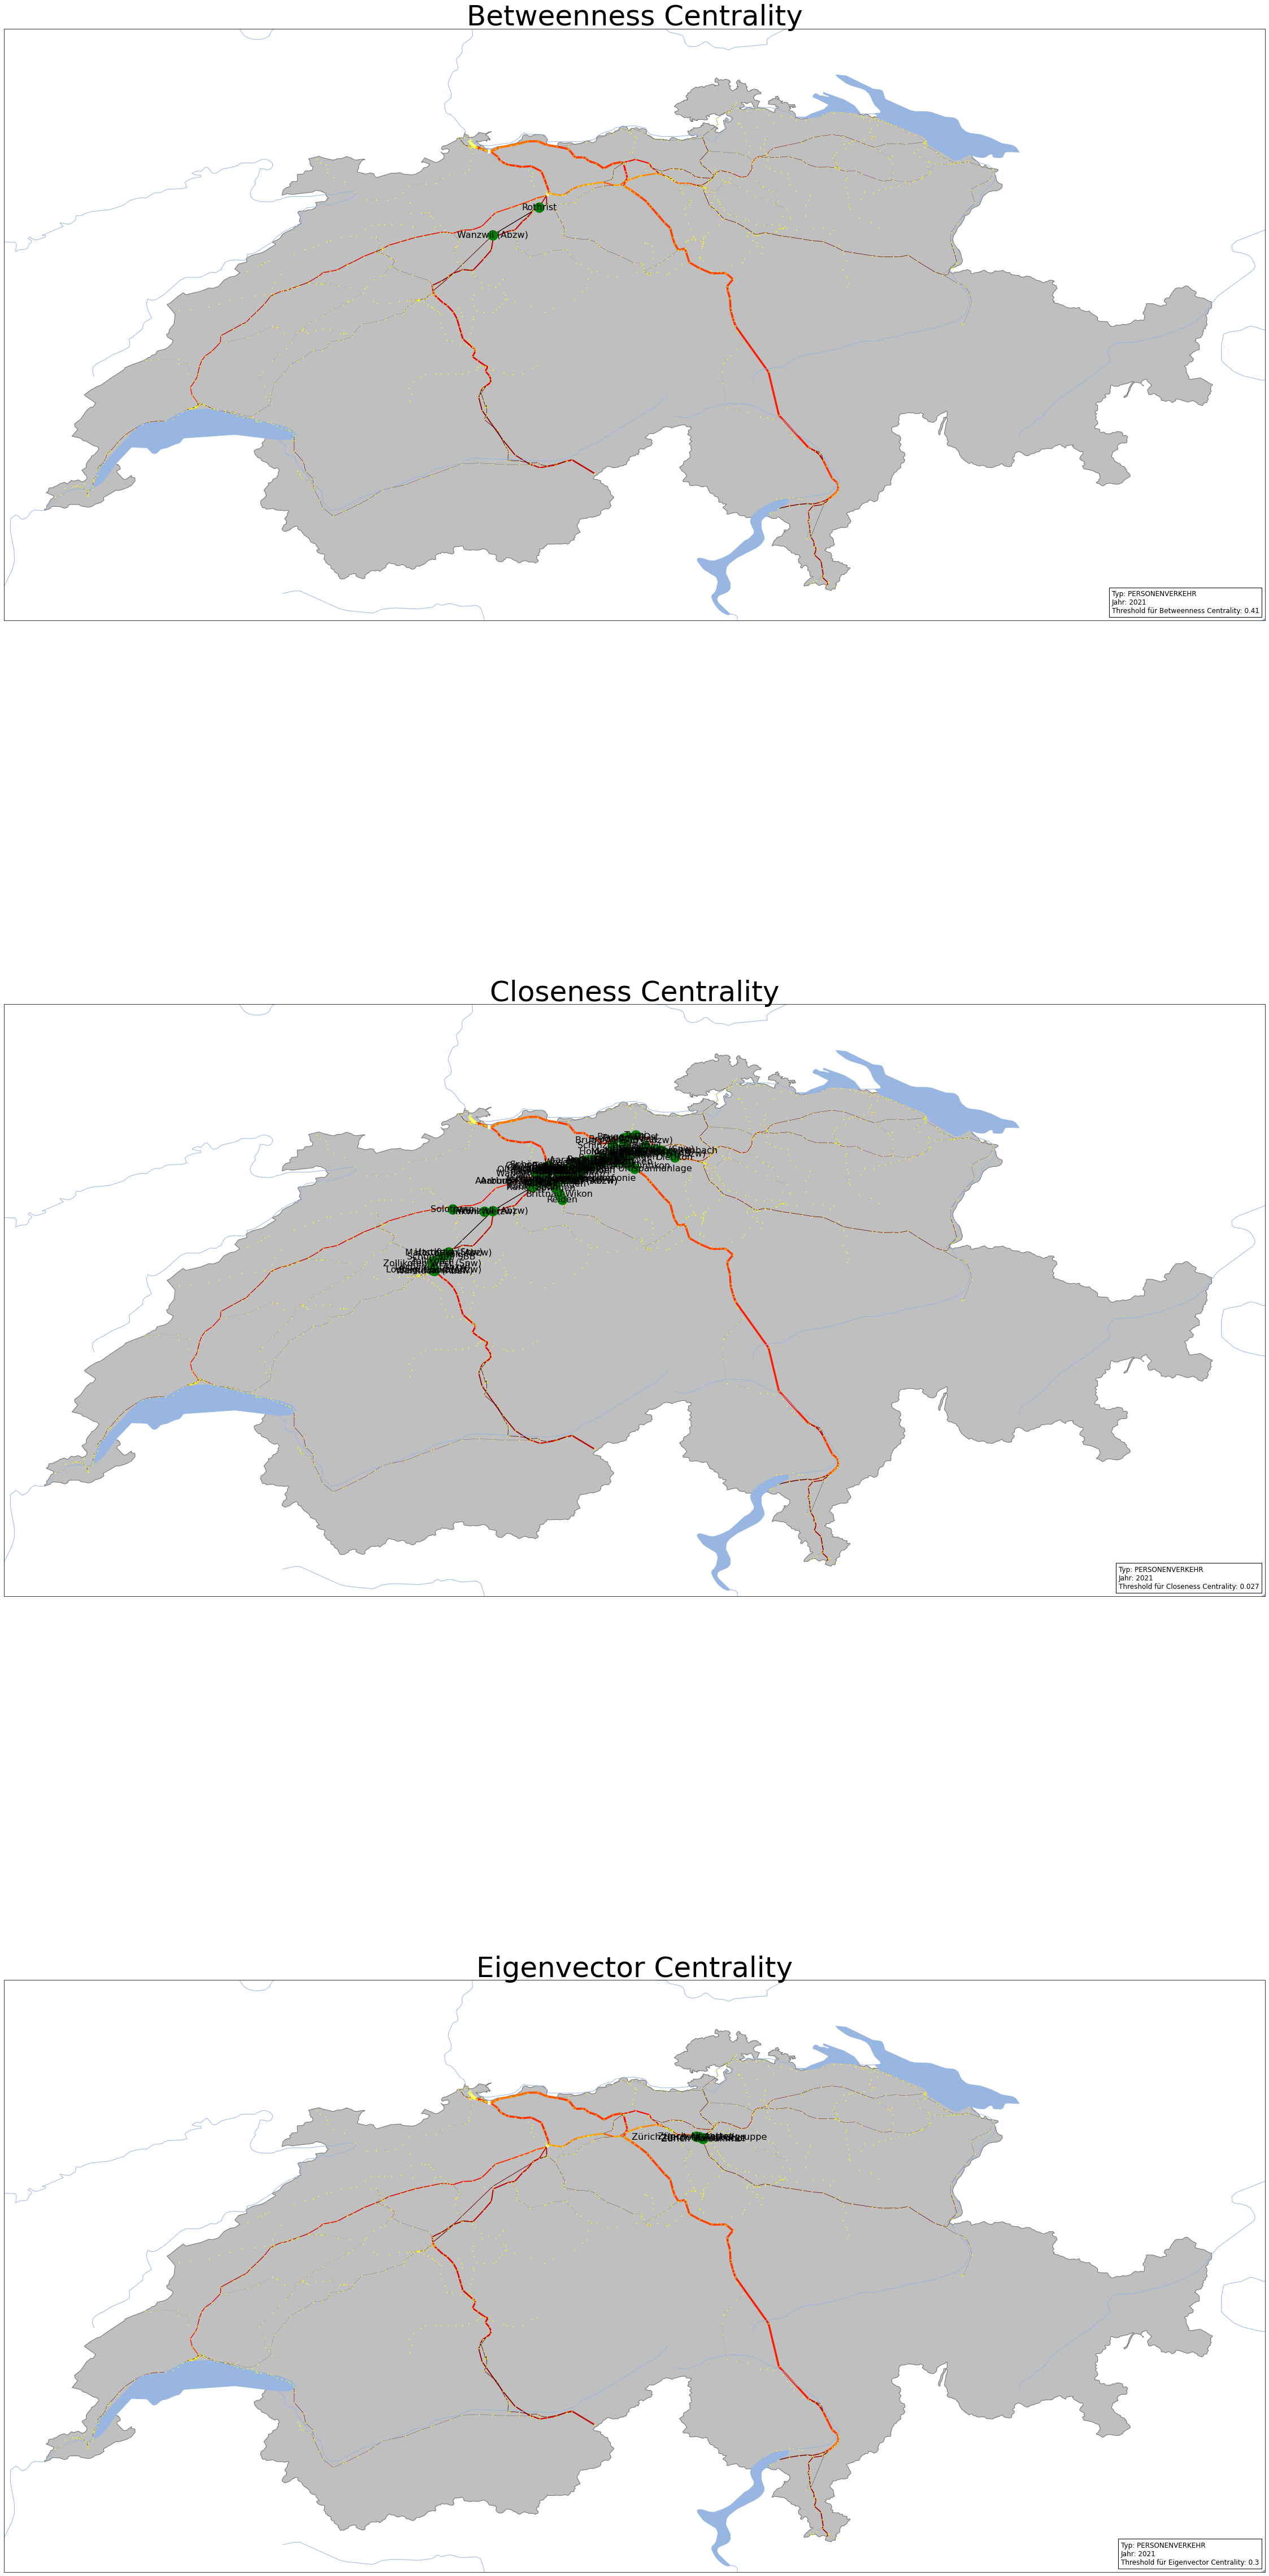

In [59]:
%%time
# Map projection
crs = ccrs.PlateCarree(central_longitude=0)
adm1_shapes = list(shpreader.Reader('.//data//shapes//gadm36_CHE_0//gadm36_CHE_0.shp').geometries()) #https://gadm.org/download_country_v3.html


plt.figure(figsize = (40,90))

ax1 = plt.subplot(3,1,1, projection = ccrs.PlateCarree())
ax1.coastlines()
plt.title('Betweenness Centrality', fontsize=50)
#ax.set_global()
ax1.set_extent([10.7, 5.8, 45.7, 48], crs=ccrs.PlateCarree())
ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='gray', alpha=0.5, zorder=0)
ax1.add_feature(cfeature.LAKES, alpha=1)
ax1.add_feature(cfeature.RIVERS)

text = AnchoredText('Typ: {} \nJahr: {} \nThreshold für Betweenness Centrality: {}'
                        ''.format(geschaeftscode, jahr, threshold_bc),
                    loc=4, prop={'size': 12}, frameon=True)
ax1.add_artist(text)

nx.draw_networkx(sg, ax=ax1,
                 font_size=16,
                 font_color='black',
                 with_labels=True,
                 alpha=1,
                 width=belastung,
                 node_size=1,
                 labels=labels_bc,
                 pos=stations,
                 node_color='yellow',
                 edge_color=anzahl_zuege,
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )

nx.draw_networkx(betweennes_graph, ax=ax1,
                with_labels=False,
                 font_color='yellow',
                 pos=stations,
                 node_color="green"
                )

ax2 = plt.subplot(3,1,2, projection = ccrs.PlateCarree())
ax2.coastlines()
plt.title('Closeness Centrality', fontsize=50)
ax2.set_extent([10.7, 5.8, 45.7, 48], crs=ccrs.PlateCarree())
ax2.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='gray', alpha=0.5, zorder=0)
ax2.add_feature(cfeature.LAKES, alpha=1)
ax2.add_feature(cfeature.RIVERS)

text = AnchoredText('Typ: {} \nJahr: {} \nThreshold für Closeness Centrality: {}'
                        ''.format(geschaeftscode, jahr, threshold_cc),
                    loc=4, prop={'size': 12}, frameon=True)
ax2.add_artist(text)

nx.draw_networkx(sg, ax=ax2,
                 font_size=16,
                 font_color='black',
                 with_labels=True,
                 alpha=1,
                 width=belastung,
                 node_size=1,
                 labels=labels_cc,
                 pos=stations,
                 node_color='yellow',
                 edge_color=anzahl_zuege,
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )

nx.draw_networkx(closeness_graph, ax=ax2,
                with_labels=False,
                 font_color='yellow',
                 pos=stations,
                 node_color="green"
                )

ax3 = plt.subplot(3,1,3, projection = ccrs.PlateCarree())
ax3.coastlines()
plt.title('Eigenvector Centrality', fontsize=50)
ax3.set_extent([10.7, 5.8, 45.7, 48], crs=ccrs.PlateCarree())
ax3.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='gray', alpha=0.5, zorder=0)
ax3.add_feature(cfeature.LAKES, alpha=1)
ax3.add_feature(cfeature.RIVERS)

text = AnchoredText('Typ: {} \nJahr: {} \nThreshold für Eigenvector Centrality: {}'
                        ''.format(geschaeftscode, jahr, threshold_ev),
                    loc=4, prop={'size': 12}, frameon=True)
ax3.add_artist(text)

nx.draw_networkx(sg, ax=ax3,
                 font_size=16,
                 font_color='black',
                 with_labels=True,
                 alpha=1,
                 width=belastung,
                 node_size=1,
                 labels=labels_ev,
                 pos=stations,
                 node_color='yellow',
                 edge_color=anzahl_zuege,
                 cmap=plt.cm.hot,
                 edge_cmap=plt.cm.hot
                )

nx.draw_networkx(eigenvector_graph, ax=ax3,
                with_labels=False,
                 font_color='yellow',
                 pos=stations,
                 node_color="green"
                )
                
plt.tight_layout
#fig.savefig('SBB_Line_'+geschaeftscode+'_'+jahr+'_bc_cc_ec.png', dpi=500)

In [51]:
#edges2=edges[:100]
#print(edges2.head())
#mini_graph=nx.from_pandas_edgelist(edges2, source='bp_von_abschnitt',target='bp_bis_abschnitt',edge_attr=('anzahl_zuege','belastung'))
#plt.figure(figsize=(40,40))
#ax = plt.subplots(1,1)

#nx.draw_networkx(mini_graph, ax=ax)

# Kombination der obigen Funktionen um verschiedene Analysen für verschiedene Jahre durchzuführen

## Laden aller Daten

In [31]:
%%time
df_envelope = [] # try as list
df_gueter = []
df_personen = []

dataset='zugzahlen'
geschaeftscodes = ['GUETERVERKEHR', 'PERSONENVERKEHR']
jahre = ['2018', '2019', '2020']

# df_envelope[0] = Güterverkehr im 2018
# df_envelope[1] = Güterverkehr im 2019
# df_envelope[2] = Güterverkehr im 2020
# df_envelope[3] = Personenverkehr im 2018
# df_envelope[4] = Personenverkehr im 2019
# df_envelope[5] = Personenverkehr im 2020

for geschaeftscode in geschaeftscodes:
    for jahr in jahre:
        print('Running ' + geschaeftscode + ' of year ' + jahr)
        
        nbr_of_rows=get_nbr_of_rec_SBB_data(dataset, geschaeftscode, jahr)
        response=get_SBB_dataset(dataset, nbr_of_rows, geschaeftscode, jahr)
        json = response.json()
        df = pd.DataFrame(json['records'])
        df=pd.concat([df.drop(['fields'], axis=1), df['fields'].apply(pd.Series)], axis=1)
        df=df.drop(['datasetid', 'recordid', 'geometry', 'record_timestamp', 'meteo', 'geoshape', 'geo_point_2d', 'geschaeftscode', 'jahr', 'lod', 'tu_nummer', 'bpuic', 'geopos'], axis=1)
        
        #Finde fehlende Koordinaten
        for i in range(len(df)):
            pos_i_coordinates=df['geopos_von'].iloc[i]
            if(isinstance(pos_i_coordinates, float)):
                pos_i_name=df['bp_von_abschnitt_bezeichnung'].iloc[i]
                pos_i_key=df['bp_von_abschnitt'].iloc[i]
                pos_i_coordinates=get_coordinates_url(pos_i_name)
                print("Found: ", pos_i_key, " (", pos_i_name, " with coordinates ", pos_i_coordinates, ")")
                df.loc[df.bp_von_abschnitt == pos_i_key, 'geopos_von']= pos_i_coordinates
                df.loc[df.bp_bis_abschnitt == pos_i_key, 'geopos_bis']= pos_i_coordinates
                time.sleep(5)

        # Koordinaten aufspliten
        temp = df['geopos_von'].str.split(", ", n = 1, expand = True)
        df['geopos_von_lon']=temp[0].astype(float)
        df['geopos_von_lat']=temp[1].astype(float)
        temp = df['geopos_bis'].str.split(", ", n = 1, expand = True)
        df['geopos_bis_lon']=temp[0].astype(float)
        df['geopos_bis_lat']=temp[1].astype(float)

        df['distance'] = df.apply(lambda row: calc_distance(row.geopos_von_lat, row.geopos_von_lon, row.geopos_bis_lat, row.geopos_bis_lon), axis=1)

        df_envelope.append(df)
        if (geschaeftscode == 'GUETERVERKEHR'): 
            df_gueter.append(df)
        if (geschaeftscode == 'PERSONENVERKEHR'):
            df_personen.append(df)


#df_envelope[0].head() # Zugzahlen 2018 Gueterverkehr
#df_envelope[1].head() # Zugzahlen 2019 Gueterverkehr
#df_envelope[2].head() # Zugzahlen 2020 Gueterverkehr

#df_envelope[3].head() # Zugzahlen 2018 Personenverkehr
#df_envelope[4].head() # Zugzahlen 2019 Personenverkehr
#df_envelope[5].head() # Zugzahlen 2020 Personenverkehr


Running GUETERVERKEHR of year 2018
Found:  LOT  ( Lottstetten  with coordinates  8.5736163, 47.6275156 )
Found:  KOGA  ( Konstanz Grenze (Abzw)  with coordinates  9.1750718, 47.659216 )
Found:  JES  ( Jestetten Süd  with coordinates  8.56667, 47.65 )
Found:  JE  ( Jestetten  with coordinates  8.56667, 47.65 )
Running GUETERVERKEHR of year 2019
Found:  JE  ( Jestetten  with coordinates  8.56667, 47.65 )
Found:  KOGA  ( Konstanz Grenze (Abzw)  with coordinates  9.1750718, 47.659216 )
Found:  JES  ( Jestetten Süd  with coordinates  8.56667, 47.65 )
Found:  LOT  ( Lottstetten  with coordinates  8.5736163, 47.6275156 )
Running GUETERVERKEHR of year 2020
Found:  JES  ( Jestetten Süd  with coordinates  8.56667, 47.65 )
Found:  LOT  ( Lottstetten  with coordinates  8.5736163, 47.6275156 )
Found:  KOGA  ( Konstanz Grenze (Abzw)  with coordinates  9.1750718, 47.659216 )
Found:  JE  ( Jestetten  with coordinates  8.56667, 47.65 )
Running PERSONENVERKEHR of year 2018
Found:  LOT  ( Lottstetten  wi

### Hilfsfunktionen für die Berechnung von weiteren Graph-Metriken

In [32]:
# Weitere Analysen:

# Gewisse Variablen für einen Graph berechnen
def gr_metrics(g):
    nodes  = g.order()
    edges  = g.size()
    degree = float(edges) / nodes
    clust_coeff = nx.clustering(g)
    avg_clust = nx.average_clustering(g)
    bet_cent = nx.betweenness_centrality(g)
    close_cent = nx.closeness_centrality(g)
    #ev_cent = nx.eigenvector_centrality(g) # Power Iteration Convergence error
    ev_cent = nx.eigenvector_centrality_numpy(g)
    return nodes, edges, degree, clust_coeff, avg_clust, bet_cent, close_cent, ev_cent


# Die obersten top Einträge zurückgeben (sortiert nach value)
def top_ent(dictionary, top):
    return dict(sorted(dictionary.items(), key=itemgetter(1), reverse = True)[:top])


# Die Abkürzung mit dem vollen Stationsnamen ersetzen und Werte runden
def full_name_rep(dictionary,runden=3):
    new_dict=dictionary
    for entry in list(dictionary):
        new_value=list(labels_all.values())[list(labels_all.keys()).index(entry)]
        new_dict[new_value] = new_dict.pop(entry)
        #print('Ersetze ', entry, ' mit ' , new_value ) # allenfalls auskommentieren, nur zur Info, ob es richtig läuft
    return {key : round(new_dict[key], runden) for key in new_dict}

# Erstelle eine Übersicht und gib diese aus
def print_overview(dictionary, jahr, metric= '', key_title = 'Betriebspunkt',value_title='Metrik-Wert', ds='Zugzahlen', gcode='Personenverkehr'):
    print('Analyse von ' + gcode + '(' + ds + ')' + ' im Jahr ' + str(jahr))
    print(key_title + '\t' + value_title + '(' + metric + ')')
    for key, value in dictionary.items():
        print('{0:20s} \t {1:.3f}'.format(key, value))
    print('\n')


# Erstelle den Graphen und füge die Kanten aus dem Dataframe ein
def create_graph(data_frame):
    g=nx.Graph()
    df=data_frame
    edges = df.groupby(['bp_von_abschnitt','bp_bis_abschnitt'],as_index=False).agg({'anzahl_zuege':'sum','gesamtbelastung_bruttotonnen':'sum'}).rename(columns={'gesamtbelastung_bruttotonnen' : 'belastung'}) 
    g = nx.from_pandas_edgelist(edges,source='bp_von_abschnitt',target='bp_bis_abschnitt',edge_attr=('anzahl_zuege','belastung'))
    return g


### Verschiedene Auswertungen für die Personen Daten zwischen 2018 und 2020

In [33]:
%%time
len(df_personen)

# define some parameters
gcode='Personenverkehr'
ds='Zugzahlen'
anzahl_tops = 4 # Anzahl der Top Einträge,
runden = 3 # Anzahl Stellen, auf welche die Werte gerundet werden sollen

pers_betweenness_cent=[]
pers_closeness_cent=[]
pers_eigenvector_cent=[]

jahr=2018
for year in df_personen:
    nodes, edges, degree, clust_coeff, avg_clust, bet_cent, close_cent, ev_cent = gr_metrics(create_graph(year))
    bet_cent_top=full_name_rep(top_ent(bet_cent, anzahl_tops), runden)
    pers_betweenness_cent.append(bet_cent_top)
    print(str(jahr))
#    print('Betweenness Centrality')
#    print(bet_cent_top)
    print_overview(bet_cent_top,jahr=jahr, metric='Bet Cent ', ds=ds,gcode=gcode)
    close_cent_top=full_name_rep(top_ent(close_cent, anzahl_tops), runden)
    pers_closeness_cent.append(close_cent_top)
#    print('Closeness Centrality')
#    print(close_cent_top)
    print_overview(close_cent_top,jahr=jahr, metric='Close Cent ', ds=ds,gcode=gcode)
    ev_cent_top=full_name_rep(top_ent(ev_cent, anzahl_tops), runden)
    pers_eigenvector_cent.append(ev_cent_top)
#    print('Eigenvector Centrality')
#    print(ev_cent_top)
    print_overview(ev_cent_top,jahr=jahr, metric='EV Cent ', ds=ds,gcode=gcode)
    jahr=jahr+1


2018
Analyse von Personenverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(Bet Cent )
Wanzwil (Abzw)       	 0.410
Rothrist             	 0.407
Aespli               	 0.374
Olten                	 0.292


Analyse von Personenverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(Close Cent )
Olten                	 0.028
Zofingen             	 0.028
Aarburg-Oftringen Süd (Abzw) 	 0.028
Aarburg-Oftringen    	 0.028


Analyse von Personenverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(EV Cent )
Zürich Altstetten    	 0.520
Zürich Vorbahnhof    	 0.386
Zürich Hardbrücke    	 0.335
Zürich Herdern Abstellgruppe 	 0.317


2019
Analyse von Personenverkehr(Zugzahlen) im Jahr 2019
Betriebspunkt	Metrik-Wert(Bet Cent )
Wanzwil (Abzw)       	 0.413
Rothrist             	 0.406
Aespli               	 0.372
Olten                	 0.287


Analyse von Personenverkehr(Zugzahlen) im Jahr 2019
Betriebspunkt	Metrik-Wert(Close Cent )
Olten                	 0.028
Zofingen             	 0.

In [34]:
df_pers_bet_cent=pd.DataFrame(pers_betweenness_cent)
df_pers_close_cent=pd.DataFrame(pers_closeness_cent)
df_pers_ev_cent=pd.DataFrame(pers_eigenvector_cent)
print('\n Betweeness Centrality:')
print(df_pers_bet_cent[df_pers_bet_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)
print('\n Closeness Centrality:')
print(df_pers_close_cent[df_pers_close_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)
print('\n Eigenvector Centrality:')
print(df_pers_ev_cent[df_pers_ev_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)



 Betweeness Centrality:
   Wanzwil (Abzw)  Rothrist  Aespli  Olten
0           0.410     0.407   0.374  0.292
1           0.413     0.406   0.372  0.287
2           0.423     0.417   0.382  0.380

 Closeness Centrality:
   Olten  Olten Nord-Ost (Abzw)  Rupperswil  Rothrist  Zofingen  \
0  0.028                    NaN         NaN       NaN     0.028   
1  0.028                    NaN         NaN       NaN     0.028   
2  0.029                  0.029       0.029     0.029       NaN   

   Aarburg-Oftringen Süd (Abzw)  Aarburg-Oftringen  
0                         0.028              0.028  
1                         0.028              0.028  
2                           NaN                NaN  

 Eigenvector Centrality:
   Zürich Altstetten  Zürich Vorbahnhof  Zürich Hardbrücke  \
0              0.520              0.386              0.335   
1                NaN                NaN                NaN   
2              0.521              0.387              0.336   

   Zürich Herdern Abste

Dasselbe noch für die Güter:

In [35]:
%%time
len(df_gueter)
# define some parameters
gcode='Güterverkehr'
ds='Zugzahlen'
anzahl_tops = 5 # Anzahl der Top Einträge,
runden = 3 # Anzahl Stellen, auf welche die Werte gerundet werden sollen

guet_betweenness_cent=[]
guet_closeness_cent=[]
guet_eigenvector_cent=[]

jahr=2018
for year in df_gueter:
    nodes, edges, degree, clust_coeff, avg_clust, bet_cent, close_cent, ev_cent = gr_metrics(create_graph(year))
    bet_cent_top=full_name_rep(top_ent(bet_cent, anzahl_tops), runden)
    guet_betweenness_cent.append(bet_cent_top)
    print(str(jahr))
    print_overview(bet_cent_top,jahr=jahr, metric='Bet Cent ', ds=ds,gcode=gcode)
    close_cent_top=full_name_rep(top_ent(close_cent, anzahl_tops), runden)
    guet_closeness_cent.append(close_cent_top)
    print_overview(close_cent_top,jahr=jahr, metric='Close Cent ', ds=ds,gcode=gcode)
    ev_cent_top=full_name_rep(top_ent(ev_cent, anzahl_tops), runden)
    guet_eigenvector_cent.append(ev_cent_top)
    print_overview(ev_cent_top,jahr=jahr, metric='EV Cent ', ds=ds,gcode=gcode)
    jahr=jahr+1


2018
Analyse von Güterverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(Bet Cent )
Rothrist             	 0.402
Wanzwil (Abzw)       	 0.402
Aespli               	 0.373
Olten                	 0.291
Löchligut (Abzw)     	 0.283


Analyse von Güterverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(Close Cent )
Olten                	 0.028
Zofingen             	 0.028
Aarburg-Oftringen Süd (Abzw) 	 0.028
Aarburg-Oftringen    	 0.028
Aarburg-Oftringen West (Abzw) 	 0.028


Analyse von Güterverkehr(Zugzahlen) im Jahr 2018
Betriebspunkt	Metrik-Wert(EV Cent )
Zürich Altstetten    	 0.520
Zürich Vorbahnhof    	 0.386
Zürich Hardbrücke    	 0.335
Zürich Herdern Abstellgruppe 	 0.317
Hard Käferberg (Abzw) 	 0.243


2019
Analyse von Güterverkehr(Zugzahlen) im Jahr 2019
Betriebspunkt	Metrik-Wert(Bet Cent )
Wanzwil (Abzw)       	 0.404
Rothrist             	 0.401
Aespli               	 0.367
Olten                	 0.288
Löchligut (Abzw)     	 0.277


Analyse von Güterverkehr(Zugzah

In [36]:
df_guet_bet_cent=pd.DataFrame(guet_betweenness_cent)
df_guet_close_cent=pd.DataFrame(guet_closeness_cent)
df_guet_ev_cent=pd.DataFrame(guet_eigenvector_cent)
print('\n Betweeness Centrality:')
print(df_guet_bet_cent[df_guet_bet_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)
print('\n Closeness Centrality:')
print(df_guet_close_cent[df_guet_close_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)
print('\n Eigenvector Centrality:')
print(df_guet_ev_cent[df_guet_ev_cent.iloc[-1,:].sort_values(ascending=False).index]) # Sortiere die Werte nach dem letzten Jahr (2020)



 Betweeness Centrality:
   Wanzwil (Abzw)  Rothrist  Aespli  Olten  Olten Nord-Ost (Abzw)  \
0           0.402     0.402   0.373  0.291                    NaN   
1           0.404     0.401   0.367  0.288                    NaN   
2           0.419     0.414   0.377  0.377                   0.32   

   Löchligut (Abzw)  
0             0.283  
1             0.277  
2               NaN  

 Closeness Centrality:
   Olten  Olten Nord-Ost (Abzw)  Rothrist  Olten Ost (Abzw)  Dulliken  \
0  0.028                    NaN       NaN               NaN       NaN   
1  0.029                    NaN       NaN               NaN       NaN   
2  0.029                  0.029     0.029             0.029     0.029   

   Zofingen  Aarburg-Oftringen Süd (Abzw)  Aarburg-Oftringen  \
0     0.028                         0.028              0.028   
1     0.029                         0.029              0.029   
2       NaN                           NaN                NaN   

   Aarburg-Oftringen West (Abzw)  
0

Grobübersicht Güter und Personen Zahlen

In [37]:
print(df_guet_bet_cent.head())
print(df_pers_bet_cent.head())

   Rothrist  Wanzwil (Abzw)  Aespli  Olten  Löchligut (Abzw)  \
0     0.402           0.402   0.373  0.291             0.283   
1     0.401           0.404   0.367  0.288             0.277   
2     0.414           0.419   0.377  0.377               NaN   

   Olten Nord-Ost (Abzw)  
0                    NaN  
1                    NaN  
2                   0.32  
   Wanzwil (Abzw)  Rothrist  Aespli  Olten
0           0.410     0.407   0.374  0.292
1           0.413     0.406   0.372  0.287
2           0.423     0.417   0.382  0.380


### Berechne Network Resilienz im Netzwerk mit k_components, d.h. es müssen mindestens k Komponenten entfernt werden, damit der Graph auseinanderbricht (Achtung, Rechenintensiv. Hat  60 Minuten gedauert und ist dann abgebrochen).

In [40]:
#k_components = nx.k_components(sg) # in der aktuellen Form gibt es nach einer Stunden einen KernelInterrupted error (out of memory)

Den Diameter und die eccentricity (Maximum nodes from a node to all other nodes in the graph) berechnen

In [60]:
%%time
print(nx.diameter(sg))
print(nx.eccentricity(sg))
print(dict(sorted(nx.eccentricity(sg).items(), key=itemgetter(1), reverse = True)[:100]))


167
{'AA': 98, 'AAGB': 99, 'AAO': 100, 'ROHS': 101, 'AAT': 126, 'WZ': 127, 'AB': 112, 'VIKT': 111, 'ABE': 88, 'LYGR': 87, 'ABO': 92, 'ABOS': 93, 'ZF': 94, 'ABOW': 92, 'AD': 138, 'GUN': 139, 'ADL': 100, 'MITH': 100, 'AE': 98, 'DOR': 99, 'AEF': 95, 'KIAL': 94, 'AESP': 88, 'LGUT': 87, 'WANZ': 89, 'AF': 127, 'MTM': 128, 'AHAU': 147, 'BERG': 146, 'AI': 145, 'SORD': 146, 'AIG': 127, 'ST': 127, 'AL': 131, 'RYN': 132, 'ALG': 148, 'UZW': 149, 'ALL': 133, 'ETOY': 132, 'ALM': 154, 'RIB': 155, 'ALN': 154, 'GUET': 153, 'LDS': 155, 'ALRH': 162, 'RCK': 163, 'ALT': 160, 'ORT': 159, 'ALTD': 133, 'LA': 134, 'AN': 134, 'HGT': 133, 'AP': 147, 'RO': 146, 'ARB': 155, 'STCH': 156, 'ARBS': 154, 'ARCY': 123, 'ARCA': 123, 'ARD': 114, 'CHF': 113, 'ARN': 151, 'GSSO': 152, 'AS': 137, 'ZGRG': 138, 'AT': 127, 'BIB': 128, 'AU': 126, 'WAE': 127, 'AUSG': 163, 'HEBG': 162, 'AUV': 105, 'NESE': 104, 'AV': 99, 'FG': 98, 'AW': 148, 'RHW': 149, 'AX': 120, 'LSA': 119, 'BAA': 128, 'BAAN': 129, 'BAAL': 128, 'ZG': 127, 'BACH': 9

Berechne den shortest path und dijkstra all pairs.

In [61]:
%%time
sg_shortest_path=nx.shortest_path(sg)
sg_shortest_path_length=nx.shortest_path_length(sg)
sg_dijkstra_all_pairs=nx.all_pairs_dijkstra(sg)

CPU times: user 38.9 s, sys: 765 ms, total: 39.6 s
Wall time: 42.4 s


In [ ]:
print(sg_shortest_path_length)
print(sg_shortest_path)

<generator object all_pairs_shortest_path_length at 0x7f46304f14d0>


## Kundenpünktlichkeits-Daten herunterladen und Prozentualer Ausfall der Züge bestimmen

In [38]:
%%time
url=f"https://data.sbb.ch/api/records/1.0/search/?dataset=ist-daten-sbb&q=&rows=-1&facet=betreiber_id&facet=produkt_id&facet=linien_id&facet=linien_text&facet=verkehrsmittel_text&facet=faellt_aus_tf&facet=ankunftszeit&facet=an_prognose&facet=an_prognose_status&facet=ab_prognose_status&facet=ankunftsverspatung&facet=abfahrtsverspatung"
response_soll_ist=requests.get(url)
json_soll_ist=response_soll_ist.json()
#print(json_soll_ist)
df_soll_ist = pd.DataFrame(json_soll_ist['records'])
df_soll_ist.head()
df_soll_ist=pd.concat([df_soll_ist.drop(['fields'], axis=1), df_soll_ist['fields'].apply(pd.Series)], axis=1)


CPU times: user 7.73 s, sys: 106 ms, total: 7.83 s
Wall time: 17.4 s


In [90]:
df_soll_ist.head()

,datasetid,recordid,geometry,record_timestamp,fahrt_bezeichner,bpuic,abfahrtsverspatung,produkt_id,betreiber_id,betriebstag,...,faellt_aus_tf,betreiber_name,geopos,zusatzfahrt_tf,durchfahrt_tf,ankunftsverspatung,ab_prognose,haltestellen_name,linien_text,an_prognose
0,ist-daten-sbb,5d5ccde57f9dafdfc088c6168e437d12d66e7cf8,"{'type': 'Point', 'coordinates': [7.9417966710...",2021-06-26T03:08:15.875000+00:00,85:11:8839:001,8502120,false,Zug,85:11,2021-06-25,...,false,Schweizerische Bundesbahnen SBB,"[47.3021415068, 7.94179667102]",false,false,false,2021-06-25T10:22:57,Küngoldingen,S28,2021-06-25T10:19:53
1,ist-daten-sbb,494898731831297dc393caae9caefae608abd1c6,"{'type': 'Point', 'coordinates': [7.9835182353...",2021-06-26T03:08:15.875000+00:00,85:11:8839:001,8502100,true,Zug,85:11,2021-06-25,...,false,Schweizerische Bundesbahnen SBB,"[47.3217579024, 7.98351823534]",false,false,false,2021-06-25T10:31:06,Safenwil,S28,2021-06-25T10:27:29
2,ist-daten-sbb,5fd0f4e495d68268b8b1b58597336a745dc7965c,"{'type': 'Point', 'coordinates': [8.0822906402...",2021-06-26T03:08:15.875000+00:00,85:11:8840:001,8502103,false,Zug,85:11,2021-06-25,...,false,Schweizerische Bundesbahnen SBB,"[47.3716354742, 8.08229064021]",false,false,false,2021-06-25T11:16:30,Suhr,S28,2021-06-25T11:12:36
3,ist-daten-sbb,d88a08a77787e497f9d326ac03393d650b44e6cf,"{'type': 'Point', 'coordinates': [8.0483871236...",2021-06-26T03:08:15.875000+00:00,85:11:8840:001,8502102,false,Zug,85:11,2021-06-25,...,false,Schweizerische Bundesbahnen SBB,"[47.3564863954, 8.04838712362]",false,false,false,2021-06-25T11:20:38,Oberentfelden,S28,2021-06-25T11:20:19
4,ist-daten-sbb,4081efeba78466df2ecf6c8439fb3e90c6b90308,"{'type': 'Point', 'coordinates': [8.0264605444...",2021-06-26T03:08:15.875000+00:00,85:11:8840:001,8502101,false,Zug,85:11,2021-06-25,...,false,Schweizerische Bundesbahnen SBB,"[47.3373001864, 8.02646054449]",false,false,false,2021-06-25T11:23:55,Kölliken,S28,2021-06-25T11:23:24


In [39]:
# Ausfall der Anzahl Züge untersuchen
#df_soll_ist.head()
print(df_soll_ist["faellt_aus_tf"].value_counts()/100)

false    98.49
true      1.51
Name: faellt_aus_tf, dtype: float64


In [ ]:
%%time
#kundenpunktlichkeit-monat (kp_m)
url=f"https://data.sbb.ch/api/records/1.0/search/?dataset=kundenpunktlichkeit-monat&q=&rows=-1&facet=monat&facet=region"
response_kp_m=requests.get(url)
json_kp_m = response_kp_m.json()
print(json_kp_m)
df_kp_m = pd.DataFrame(json_kp_m['records'])
df_kp_m.head()
df_kp_m=pd.concat([df_kp_m.drop(['fields'], axis=1), df_kp_m['fields'].apply(pd.Series)], axis=1)
#print(df_kp_m.head())
#print(df_kp_m.columns.values)
df_kp_m=df_kp_m.drop(['datasetid', 'recordid', 'record_timestamp'], axis=1)
#print(df_kp_m.head(10))
df_kp_m_clean=df_kp_m.dropna(thresh=4)
#print(df_kp_m_clean.head(10))

df_kp_m_clean_sort=df_kp_m_clean.sort_values(by=['region','monat'])
print(df_kp_m_clean_sort.head(10))


# Kundenpünktlichkeit Fern-/Regionalverkehr: KPP FV/RV
# Zugspünktlichkeit: ZP

# NETZ = gesamtes SBB Netz
# ROT = Region Ost
# RME = Region Mitte
# RSD = Region Süd
# RWT = Region West

# visualisiert hier: 
# https://company.sbb.ch/content/dam/internet/corporate/de/ueber-die-sbb/die-sbb-bewegt-die-schweiz/die-sbb-in-den-augen-der-kunden/Puenktlichkeit-im-Jahr-2019.pdf.sbbdownload.pdf

{'nhits': 37, 'parameters': {'dataset': 'kundenpunktlichkeit-monat', 'timezone': 'UTC', 'rows': 10000, 'start': 0, 'format': 'json', 'facet': ['monat', 'region']}, 'records': [{'datasetid': 'kundenpunktlichkeit-monat', 'recordid': '3b52c1e069abd7f9c5e8138ee1ffa02d61eba6a9', 'fields': {'kpp_rv': 95.3347481458, 'kpp': 94.0654656451, 'cor': 99.2302251071, 'zpk_fv': 91.580977567, 'jahr': '2021', 'region': 'BLS', 'zpk': 90.9095124692, 'kap_rv': 95.5059339186, 'kcor': 98.5801537594, 'kap_fv': 91.995073123, 'zpk_rv': 90.822308177, 'kap': 94.4660248258, 'key': '2021-1-BLS_2021', 'monat': '2021-01', 'filename': 'Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03-06-42-07', 'kpp_fv': 91.6268925747}, 'record_timestamp': '2021-06-03T02:43:00+00:00'}, {'datasetid': 'kundenpunktlichkeit-monat', 'recordid': '209ee982f509ea65d5cda6ccc46c0e5c8bf460e5', 'fields': {'kpp_rv': 92.6192750298, 'kpp': 92.2357959185, 'cor': 98.8690580187, 'zpk_fv': 92.5662519747, 'jahr': '2021', 'region': 'RWT', 'zpk': 90.68018757

In [ ]:
# Kundenpünktlichkeit
dataset='kundenpunktlichkeit-tag'
dataset='kundenpunktlichkeit-monat'
#geschaeftscode='GUETERVERKEHR'
geschaeftscode='PERSONENVERKEHR'
geschaeftscode='nan'
jahr='2020'
jahr='nan'
nbr_of_rows=get_nbr_of_rec_SBB_data(dataset, geschaeftscode, jahr)
response=get_SBB_dataset(dataset, nbr_of_rows, geschaeftscode, jahr)
json=response.json()
print(json)
response2=requests.get(f"https://data.sbb.ch/api/records/1.0/search/?dataset=kundenpunktlichkeit-monat&q=&rows=-1&facet=monat&facet=region")
json2=response2.json()
print(json2)

{'nhits': 37, 'parameters': {'dataset': 'kundenpunktlichkeit-monat', 'timezone': 'UTC', 'rows': 37, 'start': 0, 'format': 'json'}, 'records': [{'datasetid': 'kundenpunktlichkeit-monat', 'recordid': '3b52c1e069abd7f9c5e8138ee1ffa02d61eba6a9', 'fields': {'kpp_rv': 95.3347481458, 'kpp': 94.0654656451, 'cor': 99.2302251071, 'zpk_fv': 91.580977567, 'jahr': '2021', 'region': 'BLS', 'zpk': 90.9095124692, 'kap_rv': 95.5059339186, 'kcor': 98.5801537594, 'kap_fv': 91.995073123, 'zpk_rv': 90.822308177, 'kap': 94.4660248258, 'key': '2021-1-BLS_2021', 'monat': '2021-01', 'filename': 'Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03-06-42-07', 'kpp_fv': 91.6268925747}, 'record_timestamp': '2021-06-03T02:43:00+00:00'}, {'datasetid': 'kundenpunktlichkeit-monat', 'recordid': '209ee982f509ea65d5cda6ccc46c0e5c8bf460e5', 'fields': {'kpp_rv': 92.6192750298, 'kpp': 92.2357959185, 'cor': 98.8690580187, 'zpk_fv': 92.5662519747, 'jahr': '2021', 'region': 'RWT', 'zpk': 90.6801875752, 'kap_rv': 93.3032511554, 'kco

In [ ]:
df_pk = pd.DataFrame(json['records'])
df_pk.head()
df_pk=pd.concat([df_pk.drop(['fields'], axis=1), df_pk['fields'].apply(pd.Series)], axis=1)
df_pk.head()
df_pk=df_pk.drop(['datasetid', 'recordid', 'record_timestamp'], axis=1)
df_pk.head()


,kpp_rv,kpp,cor,zpk_fv,jahr,region,zpk,kap_rv,kcor,kap_fv,zpk_rv,kap,key,monat,filename,kpp_fv
0,95.334748,94.065466,99.230225,91.580978,2021,BLS,90.909512,95.505934,98.580154,91.995073,90.822308,94.466025,2021-1-BLS_2021,2021-01,Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03...,91.626893
1,92.619275,92.235796,98.869058,92.566252,2021,RWT,90.680188,93.303251,97.809603,92.952746,90.061731,93.103956,2021-2-RWT_2021,2021-02,Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03...,91.961737
2,94.779976,94.485895,99.005743,93.824648,2021,RSD,92.267149,95.240124,98.427337,94.172655,91.637931,94.771895,2021-3-RSD_2021,2021-03,Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03...,94.163621
3,92.139131,91.721295,98.891868,92.333345,2021,RWT,89.807497,93.087545,97.848589,92.759448,89.020409,92.904044,2021-3-RWT_2021,2021-03,Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03...,91.411249
4,96.551578,95.549364,99.691705,92.290534,2021,BLS,92.367703,96.834995,99.118806,93.866378,92.377465,95.958903,2021-4-BLS_2021,2021-04,Kennzahlen_Reiseverkehr_Regionen_MT_2021-05-03...,93.607133


In [ ]:
df_pk2 = pd.DataFrame(json2['records'])
print(df_pk2.head())
#to be continued


#df_pk2=pd.concat([df_pk2.drop(['fields'], axis=1), df_pk2['fields'].apply(pd.Series)], axis=1)
#df_pk2.head()
#df_pk2=df_pk2.drop(['datasetid', 'recordid', 'record_timestamp'], axis=1)
#df_pk2.head()

                   datasetid                                  recordid  \
0  kundenpunktlichkeit-monat  3b52c1e069abd7f9c5e8138ee1ffa02d61eba6a9   
1  kundenpunktlichkeit-monat  209ee982f509ea65d5cda6ccc46c0e5c8bf460e5   
2  kundenpunktlichkeit-monat  eca30832065fac0a93e6626c9b6837aa1b666d6b   
3  kundenpunktlichkeit-monat  a3b2e4f40e47dbe9ed4da406c247992cd83ec5cf   
4  kundenpunktlichkeit-monat  0ec2d22ceae49ecafd45c55670bfefcd6eae4c55   

                                              fields  \
0  {'kpp_rv': 95.3347481458, 'kpp': 94.0654656451...   
1  {'kpp_rv': 92.6192750298, 'kpp': 92.2357959185...   
2  {'kpp_rv': 94.7799761082, 'kpp': 94.4858954774...   
3  {'kpp_rv': 92.1391311793, 'kpp': 91.7212952844...   
4  {'kpp_rv': 96.5515777951, 'kpp': 95.5493637372...   

            record_timestamp  
0  2021-06-03T02:43:00+00:00  
1  2021-06-03T02:43:00+00:00  
2  2021-06-03T02:43:00+00:00  
3  2021-06-03T02:43:00+00:00  
4  2021-06-03T02:43:00+00:00  


In [ ]:
print(sg_dijkstra_all_pairs)

# Lessons learned
- PreProcessing ist extrem zeitaufwändig
- Zusammenführen verschiedener Datenquellen ist mühsam. Oft sind die Bezeichnungen anders, Einträge fehlen etc. (obwohl SBB DATA API eine Dokumentation hat) 
- Auslesen der Daten via API war viel aufwändiger als direkt das CSV zu laden (man muss zuerst die Struktur des JSON verstehen, API ist limitiert: Anzahl Abfragen pro Tag, Anzahl Records pro Abfrage

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eafae4dd-1ea9-471d-97c0-1810816b120a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>